In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#stochastic RNN to sample GSM

In [3]:
#first test: sample a joint Gaussian

In [4]:
#2D covariance matrix
sigma_target = torch.tensor([[0.8,0.3],[0.3,0.8]])

#3 neurons, 2E, 1I


In [5]:
torch.randn(3,2)

tensor([[ 2.3753, -0.1856],
        [-0.3850, -0.2566],
        [-0.0443, -0.7837]])

In [6]:
#RNN example:
#input: cos(theta), sin(theta)
#learn: output single parameter theta
#20 neurons, ReLU non-linearity
class network1():
    def forward(w,w1,dt,tau):
        #theta: 100 random angles
        #w = torch.cat((torch.exp(e_log),-torch.exp(i_log)),axis = 1)
        x = torch.rand(4,1)
        x_l = torch.zeros(30000,4)
        for i in range(30000):
            x = x + 1/tau*(-x+torch.matmul(w,x))*dt + (2/tau)**0.5*dt**0.5*torch.randn(4,1)
            x_l[i] = x.T
        x_l = x_l[2000:,:]
        cov_1 = torch.cov(x_l.T)[:2,:2]
        mu = torch.mean(x_l,axis = 0)
        L = 8*torch.sum(((1/28000*x_l.T@x_l)[:2,:2]-sigma_target)**2) + torch.sum(mu**2) + 12*(torch.var(x_l[:,0])-sigma_target[0,0])**2 + 12*(torch.var(x_l[:,1])-sigma_target[1,1])**2
        return L

In [7]:
max_eig = True
while max_eig:
    e_log = torch.autograd.Variable(torch.randn(4,2),requires_grad = True)
    i_log = torch.autograd.Variable(torch.randn(4,2),requires_grad = True)
    w = torch.cat((torch.exp(e_log),-torch.exp(i_log)),axis = 1)
    if torch.max(torch.real((torch.linalg.eig(w.detach())[0])))<1:
        max_eig = False
w1 = torch.autograd.Variable(torch.randn(3,3),requires_grad = True)

In [14]:
dt = 0.001
tau = 0.02

optimizer = torch.optim.Adam([e_log,i_log], 0.1)
m = torch.nn.Tanh()

loss_list = []
for i in range(100):
    optimizer.zero_grad()
    w = torch.cat((torch.exp(e_log),-torch.exp(i_log)),axis = 1)
    L = network1.forward(w,w1,dt,tau)
    L1 = L.detach().numpy().copy()
    print(L1)
    if np.isnan(L1) == True:
        print('error')
        break
    L.backward()
    optimizer.step()
    loss_list.append(L1)

1.0198623
0.7521061
0.23411958
0.23335731
0.06544374
0.06715281
0.03771534
0.06805277
0.0050288416
0.032952704
0.1456429
0.047546405
0.069103055
0.048606172
0.038474515
0.02375243
0.0041461177
0.00864475
0.15267046
0.014962604
0.028758842
0.054789342
0.052771796
0.039014306
0.04779767
0.07232195
0.05575762
0.03784421
0.072917864
0.012039395
0.0033418608
0.013905555
0.04035009
0.022652382
0.023796527
0.017984947
0.027374204
0.04248219
0.051685825
0.012513333
0.05169442
0.011649498
0.035523348
0.0063810023
0.01950366
0.05602078
0.0056105712
0.008896086
0.049857643
0.06447976
0.01122512
0.008104641
0.027302936
0.028308064
0.00625607
0.048176065
0.008938643
0.008510708
0.028275758
0.033897605
0.014472776
0.062065344
0.009497494
0.0367327
0.010449951
0.033512894
0.020582916
0.020505471
0.0059143817
0.121616565
0.08506579
0.013788618
0.056470536
0.07745684
0.073214695
0.009532262
0.0221796
0.046102267
0.0933658
0.1792503
0.011379859
0.056513045
0.20214821
0.15344116
0.11866099
0.03219665
0.1

array(0.01404304, dtype=float32)

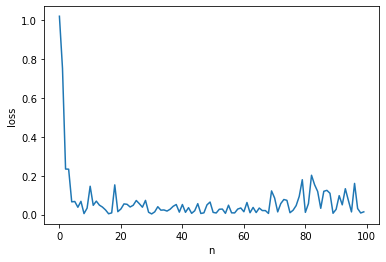

In [15]:
plt.plot(np.array(loss_list))
plt.xlabel('n')
plt.ylabel('loss')
loss_list[-1]

In [16]:
x = torch.rand(4,1)
x_l = torch.zeros(20000,4)
for i in range(20000):
    x = x + 1/tau*(-x+torch.matmul(w,x))*dt + (2/tau)**0.5*dt**0.5*torch.randn(4,1)
    x_l[i] = x.T
x_l = x_l[2000:,:]
cov_1 = torch.cov(x_l.T)[:2,:2]
mu = torch.mean(x_l,axis = 0)
print(cov_1)
print(mu)
print(w)

tensor([[0.8078, 0.3405],
        [0.3405, 0.8434]], grad_fn=<SliceBackward0>)
tensor([-0.0131,  0.0736,  0.0515, -0.0130], grad_fn=<MeanBackward1>)
tensor([[ 0.1664,  2.0850, -2.9634, -2.4025],
        [ 0.7747,  0.4395, -2.2846, -1.9830],
        [ 1.2603,  2.6418, -3.8016, -0.5738],
        [ 3.7614,  0.4887, -0.2834, -6.7859]], grad_fn=<CatBackward0>)


In [2]:
#training RNN to sample from GSM
#main source: cortical like dynamic in RNN optimized for probablistic inference
#due to instability, train 2E + 2I only


In [2]:
#gsm target
def gsm_sigma(A,C,z,x,sigma_x):
    sigma_gsm = torch.linalg.inv((torch.linalg.inv(C) + z**2/sigma_x**2*A@A.T))
    mu_gsm = z/sigma_x**2*sigma_gsm@A.T@x
    return sigma_gsm, mu_gsm

In [17]:
class network2():
    def forward(w,theta,x,dt,tau):
        #w = torch.cat((torch.exp(e_log),-torch.exp(i_log)),axis = 1)
        tau_m = tau
        u = torch.rand(4,1)
        u_l = torch.zeros(30000,4)
        for i in range(30000):
            u = u + 1/tau*(-u+torch.matmul(w,h(u)) + theta[0]*(x+theta[1])**3)*dt + (2/tau_m)**0.5*dt**0.5*torch.randn(4,1)
            u_l[i] = u.T
        u_l = u_l[2000:,:]
        cov_1 = torch.cov(u_l.T)[:2,:2]
        mu = torch.mean(u_l,axis = 0)
        return cov_1, mu
    def loss(cov_1, mu, cov_target, mu_target):
        cov_loss = 8*torch.sum((cov_1-cov_target)**2)
        mu_loss = 8*torch.sum((mu-mu_target)**2)
        var_loss = 12*(cov_1[0,0] - cov_target[0,0])**2 + 12*(cov_1[1,1] - cov_target[1,1])**2
        return cov_loss+mu_loss+var_loss
        

In [4]:
max_eig = True
while max_eig:
    e_log = torch.autograd.Variable(torch.randn(4,2),requires_grad = True)
    i_log = torch.autograd.Variable(torch.randn(4,2),requires_grad = True)
    w = torch.cat((torch.exp(e_log),-torch.exp(i_log)),axis = 1)
    if torch.max(torch.real((torch.linalg.eig(w.detach())[0])))<1:
        max_eig = False

In [5]:
theta = torch.autograd.Variable(torch.tensor([1.0,0.0]),requires_grad = True)

In [6]:
h = torch.nn.ReLU()
dt = 0.001
tau = 0.02

A = torch.tensor([[0.8,0.3],[0.3,0.8]])
C = torch.eye(2)
sigma_x = 0.2
z_l = torch.tensor([0,0.25,0.5,1,2])

y_true = torch.randn(5,2,1)

x = torch.zeros(5,2,1)

for i in range(len(z_l)):
    x_i = z_l[i]*A@y_true[i] + 0.2*torch.randn(2,1)
    x[i,:,:] = x_i

optimizer = torch.optim.Adam([e_log,i_log, theta], 0.002)

In [22]:
e_log_mid,i_log_mid, theta_mid = e_log, i_log, theta
optimizer = torch.optim.Adam([e_log,i_log,theta], 0.0005)

In [23]:
loss_list = []
import sys
for m in range(10):
    optimizer.zero_grad()
    w = torch.cat((torch.exp(e_log),-torch.exp(i_log)),axis = 1)
    for k in range(30):
        L = 0
        y_true = torch.randn(5,2,1)

        x = torch.zeros(5,2,1)

        for i in range(len(z_l)):
            x_i = z_l[i]*A@y_true[i] + torch.randn(2,1)*0.2
            x[i,:,:] = x_i
        for i in range(5):
            zi = z_l[i]
            xi = x[i]
            cov_target, mu_target = gsm_sigma(A,C,zi,xi,sigma_x)
            xi = torch.cat((xi,torch.zeros((2,1))),axis = 0)
            cov_1, mu_1 = network2.forward(w,theta,xi,dt,tau)
            L = L+network2.loss(cov_1, mu_1, cov_target, mu_target)
            L = L/3
    
    L1 = L.detach().numpy().copy()
    print(L1)
    loss_list.append(L1)

    if np.isnan(L1) == True:
        print('error')
        sys.exit(0)
    if L1<5000:
        L.backward()
        optimizer.step()

997.7432
524.2869
826.929
4245.697
886.11035
2671.862
575.5374
1166.5406
1390.0269
783.66254


In [24]:
theta

tensor([ 0.9756, -0.0024], requires_grad=True)

In [25]:
torch.cat((torch.exp(e_log),-torch.exp(i_log)),axis = 1)

tensor([[ 0.2607,  0.1645, -9.5982, -0.4041],
        [ 0.3095,  0.4036, -2.6285, -1.3609],
        [ 0.6122,  0.6827, -0.6122, -1.7938],
        [ 0.7754,  0.1773, -2.4933, -2.9959]], grad_fn=<CatBackward0>)

In [ ]:
y_true_test = torch.randn(2,1)
x = torch.zeros(5,2,1)

for i in range(len(z_l)):
    x_i = z_l[i]*A@y_true + torch.randn(2,1)
    x[i,:,:] = x_i